# Homework 2: Predicting Housing Prices

In [13]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import os
from subprocess import call, check_output
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

#call(['unzip','all.zip'])

os.listdir()

['test.csv.gz',
 'sample_submission.csv.gz',
 'test.csv',
 'data_description.txt',
 'all.zip',
 'train.csv',
 '.ipynb_checkpoints',
 'hw2.ipynb',
 'train.csv.gz',
 'sample_submission.csv']

## Data Cleaning

I'm going to read in both train and test. I will create my own train and test later.

In [2]:
houses = pd.read_csv('train.csv')
#test  = pd.read_csv('test.csv')
#houses = pd.concat([train, test])

Here are some quick and messy looks at our data. This gives us an initial sense of the values in the data.

In [3]:
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
houses.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Missing Values

In [5]:
print('observations', houses.shape[0], '\n')

def missing_values(df):
    missingDict = {}
    for var in df.columns:
        missingDict[var] = df[df[var].isnull()].shape[0]

    return pd.Series(missingDict).sort_values(ascending=False)

missing_values(houses)

observations 1460 



PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageFinish       81
GarageCond         81
GarageYrBlt        81
GarageQual         81
GarageType         81
BsmtExposure       38
BsmtFinType2       38
BsmtCond           37
BsmtFinType1       37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Condition1          0
Condition2          0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
GarageCars          0
GarageArea          0
Functional          0
FullBath            0
Foundation          0
Fireplaces          0
                 ... 
SaleCondition       0
SalePrice           0
SaleType            0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         0
Utilities           0
WoodDeckSF          0
YearBuilt           0
OverallCond         0
Neighborhood        0
HalfBath            0
MoSold              0
YearRemodA

There are quite a few missing values. Luckily, data_description.txt states what some of those values should be.

It looks like that fixed a lot of the missing values. However, there are still some other missing values that we need to deal with. Some of these are numerical variables of elements that we fixed above, so we'll first code those as zero.

In [7]:
def clean_NA(df, varList, replacementValue):
    for var in varList:
        df.loc[houses[var].isnull(),var] = replacementValue
    return 0

changeToNone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',\
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
changeToZero = ['GarageCars', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  \
                'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath']
changeToOth = ['SaleType', 'Exterior1st', 'Exterior2nd']
varLists = [changeToNone, changeToZero, changeToOth]
replacementValues = ['None', 0, 'Oth']
for params in zip(varLists, replacementValues):
    clean_NA(houses, params[0], params[1])

missing_values(houses)


#TODO should GarageYrBlt be 0 if it's a year?
#Not included: Electrical, KitchenQual, Functional, Utilities, MSZoning
#Need to still work out: LotFrontage, SalePrice

LotFrontage      259
GarageYrBlt       81
Electrical         1
ExterQual          0
Exterior1st        0
Exterior2nd        0
Fence              0
FireplaceQu        0
Fireplaces         0
Foundation         0
FullBath           0
EnclosedPorch      0
Functional         0
GarageArea         0
GarageCars         0
GarageCond         0
GarageFinish       0
GarageQual         0
GarageType         0
ExterCond          0
YrSold             0
HalfBath           0
Condition2         0
2ndFlrSF           0
3SsnPorch          0
Alley              0
BedroomAbvGr       0
BldgType           0
BsmtCond           0
BsmtExposure       0
                ... 
SaleType           0
OpenPorchSF        0
ScreenPorch        0
Street             0
TotRmsAbvGrd       0
TotalBsmtSF        0
Utilities          0
WoodDeckSF         0
YearBuilt          0
OverallCond        0
Neighborhood       0
HeatingQC          0
LotConfig          0
HouseStyle         0
Id                 0
KitchenAbvGr       0
KitchenQual  

We also need to change LotFrontage, but this has no clue as to why this is missing. Let's look closer at LotFrontage.

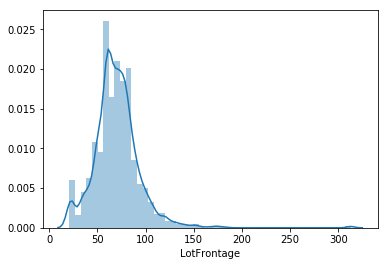

In [18]:
sns.distplot(houses.loc[~houses.LotFrontage.isnull(),'LotFrontage'])

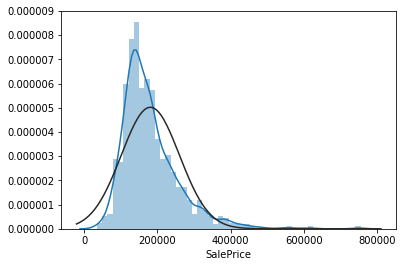

In [14]:
sns.distplot(houses.SalePrice, bins=50, fit=norm)

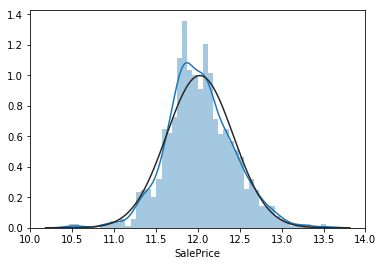

In [15]:
sns.distplot(np.log(houses.SalePrice), bins=50, fit=norm)

In [16]:
houses.SalePrice = np.log(houses.SalePrice)

In [10]:
scaler = StandardScaler()
scaler.fit(train)
scaler_train = scaler.transform(train)

ValueError: could not convert string to float: 'Normal'